In [1]:
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
nx.__version__

import numpy as np
from numpy import array
import tabulate

In [2]:
# TO SET
H = 30 # total simulation time, minutes
delta = 1 # clock interval
n_V = 5 # number of vehicles
drive_v = .1 # driving speed (leave the decimal at end)
walk_v = drive_v / 5. # walking speed (leave the decimal at end)
U = 100. # global utility for each trip

# TO DERIVE -- DO NOT TOUCH
h = 0 # current interval, starts at t=0
headway = H / float(n_V)

print tabulate.tabulate([("total time", "{} minutes".format(H)),
                         ("clock interval", "{} minute(s)".format(delta)),
                         ("# vehicles", n_V),
                         ("trip utility", "{} utils".format(U)),
                         ("headway", "{} minutes / vehicle".format(headway)),
                         ("walking speed", "{} units / minute".format(walk_v)),
                         ("driving speed", "{} units / minute".format(drive_v))], headers=("parameter", "value"))

parameter       value
--------------  ---------------------
total time      30 minutes
clock interval  1 minute(s)
# vehicles      5
trip utility    100.0 utils
headway         6.0 minutes / vehicle
walking speed   0.02 units / minute
driving speed   0.1 units / minute


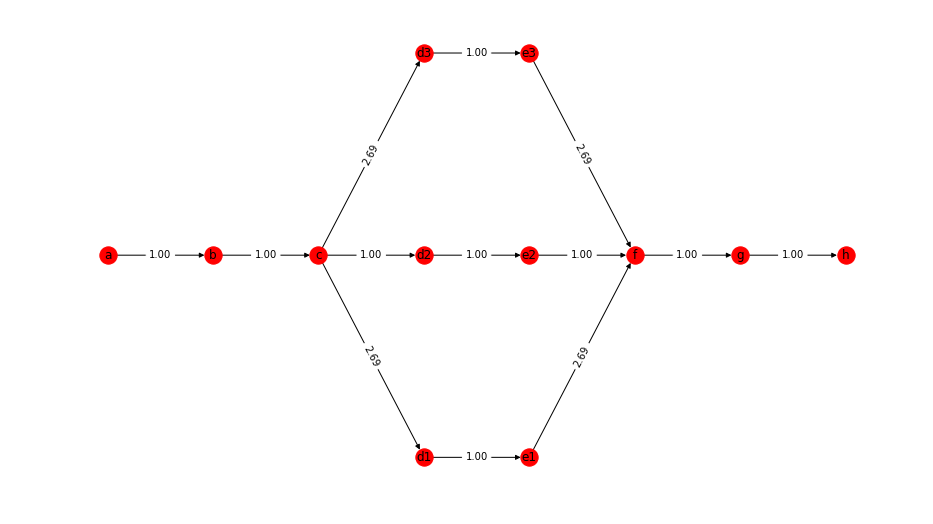

In [3]:
nodes = {"a": {"demand": 1, # this is a lambda parameter for a poisson for demands
               "pos": array([.2, .25])}, #[x,y] ranges between 0,1, for visualization purposes
         "b": {"demand": 1,
               "pos": array([.3, .25])},
         "c": { "demand": 1,
                "pos": array([.4, .25])},
         "d1": {"pos": array([.5, 0])},
         "d2": {"pos": array([.5, .25])},
         "d3": {"pos": array([.5, .5])},
         "e1": {"pos": array([.6, 0])},
         "e2": {"pos": array([.6, .25])},
         "e3": {"pos": array([.6, .5])},
         "f": {"pos": array([.7, .25])},
         "g": {"pos": array([.8, .25])},
         "h": {"pos": array([.9, .25])},
        }

demand_nodes = np.array([(k, n["demand"]) for k,n in nodes.iteritems() if "demand" in n])

# transition probability matrix -- uniform rn
transitions = {"a": {"d1": .42,
                     "d2": .0,
                     "d3": .0,
                     "e1": .43,
                     "e2": .00,
                     "e3": .00,
                     "f": .05,
                     "g": .05,
                     "h": .05},
               "b": {"d1": .42,
                     "d2": .0,
                     "d3": .0,
                     "e1": .43,
                     "e2": .0,
                     "e3": .0,
                     "f": .05,
                     "g": .05,
                     "h": .05},
               "c": {"d1": .42,
                     "d2": .0,
                     "d3": .0,
                     "e1": .43,
                     "e2": .0,
                     "e3": .0,
                     "f": .05,
                     "g": .05,
                     "h": .05}}
d_probs_by_origin = defaultdict(list)
d_names_by_origin = defaultdict(list)
for origin, probs in transitions.iteritems():
    for name, prob in probs.iteritems():
        d_probs_by_origin[origin].append(prob)
        d_names_by_origin[origin].append(name)

edges = {("a", "b"): {"weight": 2},
         ("b", "c"): {"weight": 2}, 
         ("c", "d1"): {"weight": 2},
         ("c", "d2"): {"weight": 2},
         ("c", "d3"): {"weight": 2},
         ("d1", "e1"): {"weight": 2},
         ("d2", "e2"): {"weight": 2},
         ("d3", "e3"): {"weight": 2},
         ("e1", "f"): {"weight": 2},
         ("e2", "f"): {"weight": 2},
         ("e3", "f"): {"weight": 2},
         ("f", "g"): {"weight": 2},
         ("g", "h"): {"weight": 2},}

def euclidean_distance(edge):
    return np.sqrt(np.sum((nodes[edge[1]]["pos"] - nodes[edge[0]]["pos"]) ** 2))

def euclidean_distance_xy(xy1, xy2):
    return np.sqrt(np.sum((xy2 - xy1) ** 2))

network = nx.DiGraph()    
for edge, _ in edges.iteritems():
    weight = {"dist": euclidean_distance(edge)}
    weight["weight"] = weight["dist"] / drive_v
    network.add_edge(edge[0], edge[1], **weight)
ordered_edges = list(nx.lexicographical_topological_sort(network))

# construct pos dict for drawing
pos = {k: v["pos"] for k, v in nodes.iteritems()}

fig, ax = plt.subplots(figsize=(16, 9))
nx.draw(network, pos=pos, with_labels=True, ax = ax)
labels = {k: "{0:.2f}".format(v) for k, v in nx.get_edge_attributes(network,'weight').iteritems()}
_ = nx.draw_networkx_edge_labels(network,pos,edge_labels=labels, ax = ax)

In [16]:
from pulp import *
import math
def possible_routes(states):
    PATHS = np.arange(1, 4)
    active_vehicles = np.array(states.keys())
    routes = ["{}_{}".format(vehicle, path) for path in PATHS for vehicle in active_vehicles]
    return routes

# big positive number
M = 1000000.

# TODO: hack, fix the hardcoded paths
def solve_lp(vehicle_states, unserved_demand, prev_states=None, debug=False):
    P = LpProblem('route_assign', LpMaximize)
    
    # variable convention: x_(demand_index)_(from)_(to)_(vehicle)_(route)
    xs = [LpVariable('x_{}_{}'.format(str(ix) + "_" + "_".join(s), r), 0, 1, LpBinary) 
          for (ix, s) in (unserved_demand)\
          for r in possible_routes(vehicle_states)]
    # variable convention: x_k_(vehicle)_(route)
    xk = [LpVariable('x_k_{}'.format(r), 0, 1, LpBinary) for r in possible_routes(vehicle_states)]
    
    # primary objective function
    things = []
    a_s_r = [compute_cost(vehicle_states, s, r, things) for s in unserved_demand for r in possible_routes(vehicle_states)]
    a_s_r = [-9999999999 if np.isinf(a) else a for a in a_s_r]
    assert len(a_s_r) == len(things)
    print tabulate.tabulate(zip(xs, a_s_r, 
                                [t[0] for t in things], 
                                [t[1] for t in things],
                                [t[2] for t in things]), ("name", "cost", "et", "tt", "wt"))
    a_k_r = [compute_dual_cost(vehicle_states, r, prev_states) for r in possible_routes(vehicle_states)]
    P += (lpDot(a_s_r, xs) + lpDot(a_k_r, xk) + 0)
    assert len(a_s_r) == len(xs)
    assert len(a_k_r) == len(xk)
    
    # all constraints
    for s, _ in enumerate(unserved_demand):
        P += (lpSum([x for x in xs if x.name.split("_")[1] == str(s)]) <= 1)
        
    # M constraint
    for route in possible_routes(vehicle_states):
        x_k_r = [x for x in xk if "_".join(x.name.split("_")[-2:]) == route]
        assert len(x_k_r) == 1
        x_k_r = x_k_r[0]
        xs_for_route = [x for x in xs if "_".join(x.name.split("_")[4:]) == route]
        P += (lpSum(xs_for_route) <= (M * (1 - x_k_r)))
    
    # sum(1 - x_k) constraint
    demands_by_vehicle = {r.split("_")[0]: [x for x in xk \
                                            if x.name.split("_")[2] == r.split("_")[0]]\
                          for r in possible_routes(vehicle_states) }
    for vehicle, x_ks in demands_by_vehicle.iteritems():
        P += (lpSum([1 - x for x in x_ks]) <= 1)
        
    return P


def compute_cost(vehicle_states, s, r, thing=None):
    vehicle, path = r.split("_")
    ix, (o, d) = s
    closest_d = get_closest_d(d, r)
    et = get_et(closest_d, d)
    tt = get_tt(path, o, closest_d)
    wt = get_wt(vehicle, vehicle_states, o)
    if thing is not None:
        thing.append((et, tt, wt))
    
    return U - sum((et, tt, wt))

# variables
# x_ix_o_d_v_r
def compute_dual_cost(vehicle_states, r, prev_states = None):
    vehicle, path = r.split("_")
    state = vehicle_states[int(vehicle)]
    a = 0.
    for ix, o, d in state["passengers"]:
        closest_d = get_closest_d(d, r)
        wt = get_wt(vehicle, vehicle_states, o)
        if math.isinf(wt):
            wt = 0.
        tt = get_tt(path, o, closest_d, pos=state["cur_xy"] )
        et = get_et(closest_d, d)
        a += (wt + tt + et)
        

    route = state["route"]
    if route == -1:
        return a
    
    for ix, o, d in state["passengers"]:            
        wt = get_wt(vehicle, vehicle_states, o)
        if math.isinf(wt):
            wt = 0.
        et = get_et(d[0] + str(route) if len(d) > 1 else d, d)
        tt = get_tt(route, o, d[0] + str(route) if len(d) > 1 else d, pos=state["cur_xy"])
        a -= (wt + et + tt)
    
    return a

def get_wt(vehicle, vehicle_states, o):
    cur_xy = vehicle_states[int(vehicle)]["cur_xy"]
    o_pos = nodes[o]["pos"]
    if cur_xy[0] > o_pos[0]:
        wt = float('inf')
    else:
        wt = euclidean_distance_xy(cur_xy, o_pos) / drive_v
    return wt

def get_et(closest_d, d):
    p1 = nodes[closest_d]['pos']
    p2 = nodes[d]['pos']
    return 0. if closest_d == d else (euclidean_distance_xy(p1, p2) / float(walk_v))

def get_closest_d(d, r):
    if d[0] in {"d", "e"}:
        closest_d = d[0] + r.split("_")[1]
    else:
        closest_d = d
    return closest_d

def get_tt(path, o, closest_d, pos=None):
    # yet another hack to determine the path being taken
    letters = [''.join(x).strip() for x in zip('abcdefgh', '   {}{}   '.format(path, path))]
    c_i, d_i = letters.index(o), letters.index(closest_d)
    path = letters[c_i:d_i + 1]  
    # if person is on bus, distance = (dist. to next node) + (dist. from that node to d)
    if pos is not None:
        path = [p for p in path if nodes[p]['pos'][0] > pos[0]]
        extra = euclidean_distance_xy(pos, nodes[path[0]]['pos'])
    else:
        extra = 0.
    total_distance = sum(euclidean_distance((path[i], path[i +1]))for i in range(len(path) - 1))
    total_distance += extra
    #for letters in 
    tt = total_distance / drive_v
    return tt

In [17]:
# define simulation functions

def get_origins(demand_nodes):
    return np.random.poisson([d[1] for d in demand_nodes])
                              
def get_destinations(demand_nodes, origin_requests):
    o_d_pairs = []
    for (origin, _), n_passengers in zip(demand_nodes, origin_requests):
        dests = np.random.choice(d_names_by_origin[origin], size=n_passengers, p=d_probs_by_origin[origin])
        for dest in dests:
            o_d_pairs.append((origin, dest))
    return o_d_pairs


# see below for what state matrix looks like
def init_vehicle_state():
    FIRST_STOP = ordered_edges[0]
    NEXT_STOP = ordered_edges[1]
    return {"cur_xy": nodes[FIRST_STOP]["pos"],
     "next_stop": NEXT_STOP,
     "route": -1,
     "et": network[FIRST_STOP][NEXT_STOP]["weight"],
     "passengers": set()}
init_vehicle_state()

{'cur_xy': array([ 0.2 ,  0.25]),
 'et': 0.99999999999999978,
 'next_stop': 'b',
 'passengers': set(),
 'route': -1}

In [19]:
# actual simulation

np.random.seed(42) # seed rng

V = set(range(n_V)) # all vehicles
A_V = set([]) # active vehicles
I_V = V.copy() # inactive vehicles
h = 0

"""
example state matrix:
{1: {"status": "driving",
     "current_stop": "a",
     "next_stop": "b",
     "et": 10}}
"""
from collections import OrderedDict
vehicle_states = OrderedDict()
prev_states = None
unserved_demand = OrderedDict()



def nice_assignment(P, verbose=False):
    """
    P: an LpProblem that has been solved
    """      
    
    assignments_by_v_r = defaultdict(set)
    for x in P.variables():
        if 'k' in x.name:
            continue
        if x.value() != 1:
            continue
        # variable convention: x_(demand_index)_(from)_(to)_(vehicle)_(route)
        _, ix, o, d, v, r = x.name.split("_")
        assignments_by_v_r[(v, r)].add((ix, o, d))
        
    if verbose:
        for (v, r), assignments in assignments_by_v_r.iteritems():
            print "===="
            print "vehicle {} is on route {}".format(v, r)
            print "passengers on this route: "
            print tabulate.tabulate(assignments, ("ix", "origin", "destination"))
    
    return assignments_by_v_r

def update_vehicles(states, assignments_by_v_r, verbose=False):
    done_vehicles = []
    done_passengers = []
    for (v, r), assignments in assignments_by_v_r.iteritems():
        state = states[int(v)]
        state['route'] = int(r)
        # add passengers
        for assignment in assignments:
            state["passengers"].add(assignment)
            
        # update x/y coords
        dest_pos = nodes[state['next_stop']]['pos']
        diffs = dest_pos - state['cur_xy']
        slope = diffs[1] / diffs[0]
        if verbose:
            print "next stop is {}".format(state['next_stop'])
            print "slope is {}".format(slope)
        
        v_y = drive_v * (diffs[1] / (diffs[0] + diffs[1]))
        v_x = drive_v * (diffs[0] / (diffs[0] + diffs[1]))
        next_pos = state['cur_xy'] + np.array([v_x, v_y])

        if verbose:
            print "y velocity is {}".format(v_y)
            print "x velocity is {}".format(v_x)
            print "next pos is {}".format(next_pos)
            
        # if outside of bounds, done
        if state['cur_xy'][0] >= 1:
            if verbose:
                print "vehicle {} is done".format(v)
            states.pop(int(v))
        
        # update next stop
        state['cur_xy'] = next_pos
        letters = 'abcdefgh'        
        if state['cur_xy'][0] >= dest_pos[0]:
            state['next_stop'] = letters[letters.index(state['next_stop'][0]) + 1]
            if state['next_stop'] in {'e', 'f'}:
                state['next_stop'] = state['next_stop'] + r
            print "next stop is {}".format(state["next_stop"])
                

MAX = 0
while h < H:
    print "h is {}".format(h)
    print "{} remain unserved".format(len(unserved_demand))

    # figuring out new requests
    o_d_pairs = get_destinations(demand_nodes, get_origins(demand_nodes))
    unserved_demand.update(OrderedDict(((ix + MAX, p,), None) for ix, p in enumerate(o_d_pairs)))
    MAX = MAX + len(o_d_pairs)
    print "demands: {}".format(len(unserved_demand))
    
    # maybe add new bus
    if not h % headway:
        next_vehicle = I_V.pop()
        print "next vehicle is {}".format(next_vehicle)
        vehicle_states[next_vehicle] = init_vehicle_state()
        A_V = A_V.union(set([next_vehicle]))
        
    print "Vehicles active: {}".format(A_V)
    if len(A_V) == 0:
        h = h + 1
        continue
        
    # solve LP
    P = solve_lp(vehicle_states, unserved_demand.keys(), prev_states, debug=(False if h == 0 else True))
    status = P.solve()
    if status != 1:
        print status
        raise Exception("Solver failed?")
        
    prev_states = P.variablesDict()
    assignments_by_vr = nice_assignment(P, verbose=True)
    assignments = sorted([(int(ix), (o, d)) for assignment in assignments_by_vr.itervalues() for ix, o, d in assignment],
                         key = lambda x: x[0])
    
    
    update_vehicles(vehicle_states, assignments_by_vr, verbose=True)
    
    # remove all assigned passengers
    for assignment in assignments:
        unserved_demand.pop(assignment)

    # only vehicles at or before c
    for vehicle in vehicle_states.keys():
        if vehicle_states[vehicle]["next_stop"] not in {"a", "b", "c"}:
            print "vehicle {} done".format(vehicle)
            vehicle_states.pop(vehicle)
            A_V.remove(vehicle)
    h = h + delta
    print "=======--======="

h is 0
0 remain unserved
demands: 3
next vehicle is 0
Vehicles active: set([0])
name             cost    et       tt    wt
------------  -------  ----  -------  ----
x_0_a_g_0_1   90.6148   0    9.38516     0
x_0_a_g_0_2   94        0    6           0
x_0_a_g_0_3   90.6148   0    9.38516     0
x_1_c_d1_0_1  95.3074   0    2.69258     2
x_1_c_d1_0_2  84.5     12.5  1           2
x_1_c_d1_0_3  70.3074  25    2.69258     2
x_2_c_d1_0_1  95.3074   0    2.69258     2
x_2_c_d1_0_2  84.5     12.5  1           2
x_2_c_d1_0_3  70.3074  25    2.69258     2
====
vehicle 0 is on route 1
passengers on this route: 
  ix  origin    destination
----  --------  -------------
   1  c         d1
   2  c         d1
   0  a         g
next stop is b
slope is 0.0
y velocity is 0.0
x velocity is 0.1
next pos is [ 0.3   0.25]
next stop is c
=======--=======
h is 1
0 remain unserved
demands: 3
Vehicles active: set([0])
name             cost    et       tt    wt
------------  -------  ----  -------  ----
x_3_a_e

Vehicles active: set([4])
name              cost    et       tt    wt
-------------  -------  ----  -------  ----
x_47_b_d1_4_1  95.3074   0    3.69258     1
x_47_b_d1_4_2  84.5     12.5  2           1
x_47_b_d1_4_3  70.3074  25    3.69258     1
x_48_b_d1_4_1  95.3074   0    3.69258     1
x_48_b_d1_4_2  84.5     12.5  2           1
x_48_b_d1_4_3  70.3074  25    3.69258     1
x_50_b_d1_4_1  95.3074   0    3.69258     1
x_50_b_d1_4_2  84.5     12.5  2           1
x_50_b_d1_4_3  70.3074  25    3.69258     1
x_51_b_e1_4_1  94.3074   0    4.69258     1
x_51_b_e1_4_2  83.5     12.5  3           1
x_51_b_e1_4_3  69.3074  25    4.69258     1
x_52_b_e1_4_1  94.3074   0    4.69258     1
x_52_b_e1_4_2  83.5     12.5  3           1
x_52_b_e1_4_3  69.3074  25    4.69258     1
x_53_b_e1_4_1  94.3074   0    4.69258     1
x_53_b_e1_4_2  83.5     12.5  3           1
x_53_b_e1_4_3  69.3074  25    4.69258     1
x_54_a_e1_4_1  94.3074   0    5.69258     0
x_54_a_e1_4_2  83.5     12.5  4           0
x_54_a